In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Shape Demo

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

In [3]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens(threshold = -19)
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace
sats_occ_model =  Zheng07Sats(threshold = -19)
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.5, 15.2, 15))

# define shape model
from shape_model_componenets import PS08Shapes, GalaxyShapes
#cens_shape_model = PS08Shapes(gal_type = 'centrals',   sample='all', galaxy_type='elliptical')
#sats_shape_model = PS08Shapes(gal_type = 'satellites', sample='all', galaxy_type='elliptical')
cens_shape_model = GalaxyShapes(gal_type = 'centrals')
sats_shape_model = GalaxyShapes(gal_type = 'satellites')

# define alignment model
from intrinsic_alignments.ia_models.ia_model_components import RandomAlignment
central_orientation_model = RandomAlignment(gal_type='centrals')
satellite_orientation_model = RandomAlignment(gal_type='satellites')

# projected shapes
from shape_model_componenets import ProjectedShape
central_proj_shapes_model = ProjectedShape('centrals')
satellite_proj_shapes_model = ProjectedShape('satellites')

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_galaxy_shape = cens_shape_model,
                                 satellites_galaxy_shape = sats_shape_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 centrals_proj_shapes = central_proj_shapes_model,
                                 satellites_proj_shapes = satellite_proj_shapes_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_galaxy_shape',
                                 'satellites_galaxy_shape',
                                 'centrals_orientation',
                                 'satellites_orientation',
                                 'centrals_proj_shapes',
                                 'satellites_proj_shapes')
                                )

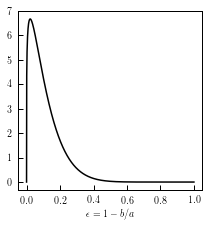

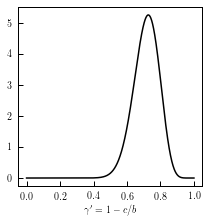

In [4]:
# examine shape distribution model

x = np.linspace(0,1,1000)
epsilon = cens_shape_model.epsilon_pdf(x)
gamma_prime = cens_shape_model.gamma_prime_pdf(x)

plt.figure(figsize=(3.3,3.3))
plt.plot(x, epsilon, color='black')
plt.xlabel(r'$\epsilon = 1-b/a$')
plt.show()

plt.figure(figsize=(3.3,3.3))
plt.plot(x, gamma_prime, color='black')
plt.xlabel(r'$\gamma^{\prime} = 1-c/b$')
plt.show()

In [5]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

mock = model_instance.mock.galaxy_table

number of galaxies:  189180


In [6]:
# calculate the distribution of shapes
bins = np.linspace(0,1,100)

# 3D axis ratios
counts_1 = np.histogram(mock['galaxy_b_to_a'], bins=bins)[0]
counts_2 = np.histogram(mock['galaxy_c_to_a'], bins=bins)[0]

# 2D elipticity
e = 1 - mock['galaxy_projected_b_to_a']
counts_3 = np.histogram(e, bins=bins)[0]
counts_3 = counts_3/np.sum(counts_3)/np.diff(bins)

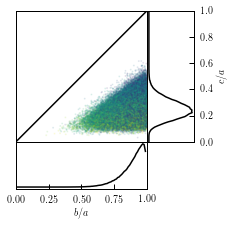

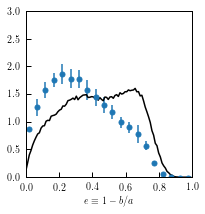

In [7]:
# 3D shape distribution
fig = plt.figure(figsize=(3.3,3.3))

# main panel
rect = 0.2-0.1, 0.35, 0.55, 0.55  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.scatter(mock['galaxy_b_to_a'], mock['galaxy_c_to_a'], alpha=0.1, s=1, c=e, rasterized=True)
ax.plot([0,1],[0,1], '-', color='black')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# lower panel
rect = 0.2-0.1,0.15,0.55,0.2  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.yaxis.set_visible(False)
ax.set_xlim([0,1])
ax.plot(bins[:-1], counts_1, color='black')
ax.set_xlabel(r'$b/a$')

# right panel
rect = 0.75-0.1,0.35,0.2,0.55  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.xaxis.set_visible(False)
ax.set_ylim([0,1])
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.plot(counts_2, bins[:-1], color='black')
ax.set_ylabel(r'$c/a$')

plt.show()

# load PS08 data
from astropy.table import Table
t = Table.read('../data/PS08/figure_4.dat', format='ascii')
x = 1-t['b/a']
y = t['normalized_frequency']
err = np.fabs(t['error_+'] - t['error_-'])


# 2D shape distribution
fig = plt.figure(figsize=(3.3,3.3))

# main panel
rect = 0.2, 0.2, 0.7, 0.7  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.plot(bins[:-1], counts_3, color='black')
ax.errorbar(x, y, yerr=err, fmt='o', ms=5)
ax.set_xlim([0,1])
ax.set_ylim([0,3])
ax.set_xlabel(r'$e \equiv 1 - b/a$')

plt.show()